#### Architecture - Semantic Search using Elastic Search


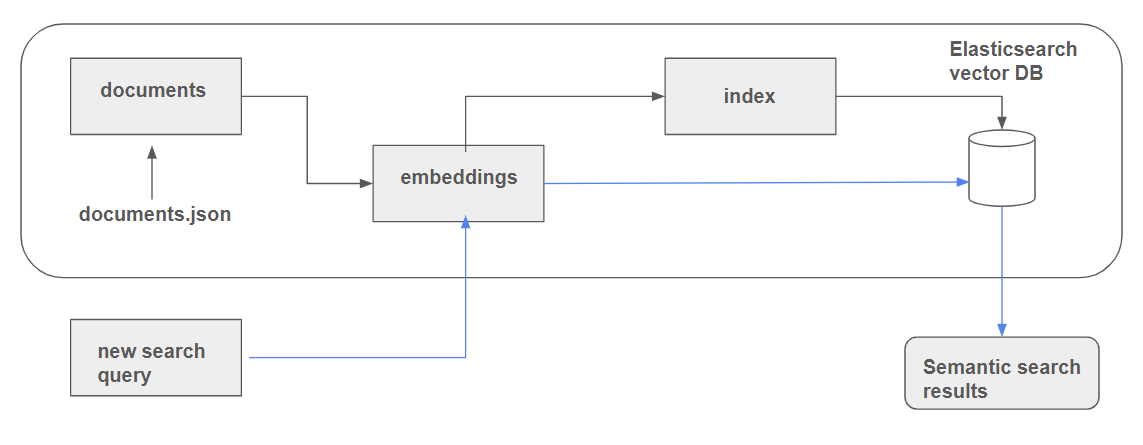

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

#### Step 1: Prepare documents

In [1]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()
len(documents)

948

In [2]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'id': '1f6520ca'}

In [41]:
filter = "machine-learning-zoomcamp"

selected_documents = [ doc for doc in documents if doc["course"]==filter]
len(selected_documents)

375

#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [3]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("multi-qa-distilbert-cos-v1")

/home/codespace/.python/current/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
user_question = "I just discovered the course. Can I still join it?"
text_vector = model.encode(user_question).tolist()
text_vector[0]

0.07822265475988388

In [6]:
len(text_vector)

768

In [42]:
selected_documents[0]

{'text': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'section': 'General course-related questions',
 'question': 'How do I sign up?',
 'course': 'machine-learning-zoomcamp',
 'id': '0227b872',
 'embedding': [0.08805905282497406,
  0.01559354830533266,
  0.07925581932067871,
  0.025275787338614464,
  0.07557650655508041,
  -0.03905969485640526,
  -0.041381385177373886,
  0.025291813537478447,
  0.02432412840425968,
  0.003625859972089529,
  -0.0072828554548323154,
  -0.03287515416741371,
  0.06129564717411995,
  -0.057110100984573364,
  0.011677478440105915,
  -0.01794421300292015,
  0.044920604676008224,
  -0.05416058748960495,


In [43]:
import numpy as np
#created the dense vector using the pre-trained model
embeddings = []
for doc in selected_documents:
    qa_text = f'{doc["question"]} {doc["text"]}'
    # Transforming qa_test into an embedding using the model
    embedding = model.encode(qa_text)
    doc["embedding"] = embedding.tolist()
    embeddings.append(embedding)

len(embeddings)

375

In [44]:
len(embeddings)
embeddings[0]

array([ 8.80590528e-02,  1.55935483e-02,  7.92558193e-02,  2.52757873e-02,
        7.55765066e-02, -3.90596949e-02, -4.13813852e-02,  2.52918135e-02,
        2.43241284e-02,  3.62585997e-03, -7.28285545e-03, -3.28751542e-02,
        6.12956472e-02, -5.71101010e-02,  1.16774784e-02, -1.79442130e-02,
        4.49206047e-02, -5.41605875e-02, -1.92261033e-03,  1.48329930e-02,
        7.91360065e-03, -3.43127362e-02,  1.21480487e-02,  1.27185713e-02,
       -1.60092711e-02,  7.12137856e-03,  1.58389509e-02, -3.27488902e-04,
        3.01296543e-03, -4.58918400e-02, -1.34775438e-03,  2.01149546e-02,
        2.33724471e-02, -4.28200746e-03, -3.09384037e-02,  1.94302748e-03,
       -1.88219752e-02,  5.35160303e-03,  1.29352352e-02, -3.23957913e-02,
        3.10556218e-02,  5.12981648e-03, -3.24394932e-04, -3.15541998e-02,
        1.93377174e-02, -6.38601556e-02, -3.05381045e-02, -6.27884790e-02,
       -1.74859781e-02,  3.52949575e-02, -2.98071913e-02,  7.45346099e-02,
       -2.06183232e-02, -

In [45]:
X = np.array(embeddings)    
X.shape

(375, 768)

In [46]:
scores = X.dot(text_vector)
max(scores)


0.6506573240979582

In [68]:
class VectorSearchEngine():
    def __init__(self, documents, embeddings):
        self.documents = documents
        self.embeddings = embeddings

    def search(self, v_query, num_results=10):
        scores = self.embeddings.dot(v_query)
        idx = np.argsort(-scores)[:num_results]
        return [self.documents[i] for i in idx]

search_engine = VectorSearchEngine(documents=selected_documents, embeddings=X)
search_engine.search(text_vector, num_results=5)

[{'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
  'section': 'General course-related questions',
  'question': 'The course has already started. Can I still join it?',
  'course': 'machine-learning-zoomcamp',
  'id': 'ee58a693',
  'embedding': [0.0806286409497261,
   -0.06663887947797775,
   0.02527306228876114,
   -0.013004408217966557,
   0.07587282359600067,
   -0.05946270748972893,
   -0.02188383787870407,
   0.0029000400099903345,
   0.0007928351988084614,
   -0.0052224150858819485,
   -0.03365179896354675,
   -0.027913514524698257,
   0.05811655521392822,
   0.039748333394527435,
   0.05441855639219284,
   -0.038251712918281555,
   0.06305737048387

In [56]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')
len(ground_truth)

1830

In [69]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [67]:
search_engine = VectorSearchEngine(documents=ground_truth, embeddings=X)
search_engine.search(text_vector, num_results=5)

[{'question': 'Can I still interact with instructors after missing a session?',
  'course': 'machine-learning-zoomcamp',
  'document': '5170565b'},
 {'question': 'Is the focus of the course more on practice or theory?',
  'course': 'machine-learning-zoomcamp',
  'document': 'ecca790c'},
 {'question': 'Are the course videos live or pre-recorded?',
  'course': 'machine-learning-zoomcamp',
  'document': '39fda9f0'},
 {'question': 'What does a low standard deviation indicate about the values?',
  'course': 'machine-learning-zoomcamp',
  'document': '266faa6d'},
 {'question': 'Is prior knowledge in math necessary for this course?',
  'course': 'machine-learning-zoomcamp',
  'document': 'c25b3de4'}]

In [70]:
search_engine.search(model.encode(ground_truth[0]['question']), num_results=5)

[{'text': 'Welcome to the course! Go to the course page (http://mlzoomcamp.com/), scroll down and start going through the course materials. Then read everything in the cohort folder for your cohort’s year.\nClick on the links and start watching the videos. Also watch office hours from previous cohorts. Go to DTC youtube channel and click on Playlists and search for {course yyyy}. ML Zoomcamp was first launched in 2021.\nOr you can just use this link: http://mlzoomcamp.com/#syllabus',
  'section': 'General course-related questions',
  'question': 'I just joined. What should I do next? How can I access course materials?',
  'course': 'machine-learning-zoomcamp',
  'id': '0a278fb2',
  'embedding': [0.04816654324531555,
   0.010786784812808037,
   0.057280465960502625,
   0.02604234777390957,
   0.10697224736213684,
   -0.038208141922950745,
   -0.024003613740205765,
   0.053581126034259796,
   -0.0370882973074913,
   -0.002349585760384798,
   0.014817310497164726,
   -0.015525924041867256

In [71]:
from tqdm.auto import tqdm

relevance_total = []

for q in tqdm(ground_truth):
    doc_id = q['document']
    q_vector = model.encode(q['question'])
    results = search_engine.search(q_vector, num_results=5)

    relevance = [d['id'] == doc_id for d in results]
    relevance_total.append(relevance)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [72]:
relevance_total

[[False, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, True, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [False, False, True, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],

In [64]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

In [73]:
hit_rate(relevance_total)

0.9398907103825137

In [ ]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
X_sparse = sparse.csr_matrix(X)
dist_out = 1-pairwise_distances(X, metric="cosine")
dist_out

#### Step 3: Setup ElasticSearch connection 

In [74]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': 'bd9eb5841c5e', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'e50isLFhQa6LGz_Ratd18Q', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [33]:
documents[2]

{'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.",
 'section': 'General course-related questions',
 'question': 'Course - Can I still join the course after the start date?',
 'course': 'data-engineering-zoomcamp',
 'id': '7842b56a',
 'embedding': [0.06149107217788696,
  -0.059441447257995605,
  0.02415304072201252,
  -0.013487491756677628,
  0.06136905029416084,
  -0.043630726635456085,
  -0.012730241753160954,
  0.03214196488261223,
  -0.024698741734027863,
  -0.0009449099306948483,
  -0.013986924663186073,
  -0.01651984639465809,
  0.08577229082584381,
  0.0022300570271909237,
  0.014002514071762562,
  -0.013182972557842731,
  0.02886749617755413,
  -0.049197353422641754,
  0.027015436440706253,
  -0.055540524423122406,
  -0.010746615938842297,
  0.014387684874236584,
  -0.02991856262087822,
  0.058576516807079315,

In [75]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "embedding": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [76]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

#### Step 5: Add documents into index

In [78]:
for doc in selected_documents:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Step 6: Create end user query

In [37]:

text_vector

[0.07822265475988388,
 -0.04013114050030708,
 0.038613591343164444,
 -0.00017896643839776516,
 0.08923470973968506,
 -0.050459109246730804,
 -0.010502656921744347,
 0.03710556775331497,
 -0.041871391236782074,
 0.034808479249477386,
 -0.01207018829882145,
 -0.02369423396885395,
 0.0387900173664093,
 0.016098860651254654,
 0.03507472947239876,
 0.003047461621463299,
 0.05796723812818527,
 -0.041062746196985245,
 -0.03415526822209358,
 -0.025639638304710388,
 -0.03552639111876488,
 0.014290808700025082,
 -0.01627999171614647,
 0.03214465454220772,
 -0.04668973758816719,
 0.07891860604286194,
 0.04901609197258949,
 0.015676116570830345,
 -0.016911007463932037,
 0.022648222744464874,
 0.05602061003446579,
 -0.039836108684539795,
 0.06774099171161652,
 -0.012020991183817387,
 0.001126218936406076,
 -0.019439436495304108,
 -0.026595167815685272,
 0.010617736726999283,
 0.016968712210655212,
 0.01134878396987915,
 -0.029706308618187904,
 0.052525825798511505,
 -0.014145354740321636,
 0.046169

In [79]:
query = {
    "field": "embedding",
    "query_vector": text_vector,
    "k": 5,
    "num_candidates": 10000, 
}

In [ ]:
res = es_client.search(index=index_name, knn=query, source=["id","text","section","question","course","embedding"])


In [91]:
res["hits"]["hits"][0]['_score']

0.82532895

In [93]:
res["hits"]["hits"][0]

{'_index': 'course-questions',
 '_id': '1oMTw5ABhc2ZJrsiNd06',
 '_score': 0.82532895,
 '_source': {'question': 'The course has already started. Can I still join it?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
  'id': 'ee58a693',
  'embedding': [0.0806286409497261,
   -0.06663887947797775,
   0.02527306228876114,
   -0.013004408217966557,
   0.07587282359600067,
   -0.05946270748972893,
   -0.02188383787870407,
   0.0029000400099903345,
   0.0007928351988084614,
   -0.0052224150858819485,
   -0.03365179896354675,
   -0.027913514524698257,
   0.0581165552139282

In [ ]:
relevance_total = []
cnt = 0
for q in ground_truth:
    doc_id = q['document']
    q_vector = model.encode(q['question'])

    query = {
        "field" : "embedding",
        "query_vector" : q_vector,
        "k" : 5,
        "num_candidates" : 10000,
    }
    result = es_client.search(index=index_name, knn=query, source=["text","section","question","course","id","embedding"])
    # print(result["hits"]["hits"][0])
    relevance = [res['_source']['id'] for res in result["hits"]["hits"]]

    if doc_id in relevance:
        cnt += 1

cnt

In [89]:
cnt/len(ground_truth)

0.9398907103825137

#### Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [ ]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [ ]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"section": "General course-related questions"},
    },
    knn=knn_query,
    size=5
)

In [ ]:
response["hits"]["hits"]

#### References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch